In [1]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from datetime import datetime

In [2]:
import seaborn as sns

In [3]:
# DATA IS FROM https://www.kaggle.com/austinreese/craigslist-carstrucks-data version 8. 
vehicles = pd.read_csv('../Raw Data/vehicles_v8.csv',parse_dates=True)

<AxesSubplot:>

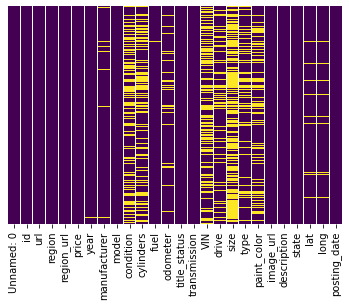

In [4]:
# CHECK FOR MISSING DATA:
sns.heatmap(vehicles.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [5]:
pd.set_option('display.max_columns', None)
vehicles.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


In [6]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [7]:
# ROMOVE IRRELEVANT COLUMNS AND COLUMNS MISSING TOO MUCH DATA
vehicles_trimmed = vehicles.drop(['Unnamed: 0','id','url','region_url',
                          'VIN','size','image_url','description'],
                         axis=1)
# REMOVE CARS PRE-1984 SO THE DATA BASE MATCHES THE RANGE OF THE EPA DATABASE
vehicles_trimmed = vehicles_trimmed[vehicles_trimmed['year'] >= 1984]

In [8]:
# DROP THE REMAINING ROWS WITH MISSING VALUES FOR SELECTED COLUMNS THAT ARE NOT MISSING A LOT OF DATA
col_keep = {'condition', 'cylinders', 'odometer','drive', 'type','paint_color'}
col_all = set(vehicles_trimmed.columns)
col_subset_remove_nan = col_all - col_keep
print(f" The following columns had rows with 'nan' values dropped: \n{col_subset_remove_nan}")

vehicles_trimmed.dropna(subset= col_subset_remove_nan, inplace=True)

 The following columns had rows with 'nan' values dropped: 
{'title_status', 'fuel', 'posting_date', 'state', 'lat', 'price', 'manufacturer', 'transmission', 'year', 'long', 'region', 'model'}


In [9]:
vehicles_trimmed = vehicles_trimmed.astype('string')
vehicles_trimmed['cylinders'] = vehicles_trimmed['cylinders'].str.extract('(\d+)', expand = False)
vehicles_trimmed['cylinders'] = vehicles_trimmed['cylinders'].astype(float)
vehicles_trimmed['price'] = vehicles_trimmed['price'].astype(float)
vehicles_trimmed['year'] = pd.to_numeric(vehicles_trimmed['year']).astype(int)
vehicles_trimmed['odometer'] = pd.to_numeric(vehicles_trimmed['odometer'])
vehicles_trimmed['lat'] = pd.to_numeric(vehicles_trimmed['lat'])
vehicles_trimmed['long'] = pd.to_numeric(vehicles_trimmed['long'])
vehicles_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416577 entries, 0 to 458211
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        416577 non-null  string 
 1   price         416577 non-null  float64
 2   year          416577 non-null  int32  
 3   manufacturer  416577 non-null  string 
 4   model         416577 non-null  string 
 5   condition     246730 non-null  string 
 6   cylinders     262836 non-null  float64
 7   fuel          416577 non-null  string 
 8   odometer      371234 non-null  float64
 9   title_status  416577 non-null  string 
 10  transmission  416577 non-null  string 
 11  drive         298809 non-null  string 
 12  type          318342 non-null  string 
 13  paint_color   290644 non-null  string 
 14  state         416577 non-null  string 
 15  lat           416577 non-null  float64
 16  long          416577 non-null  float64
 17  posting_date  416577 non-null  string 
dtypes: f

In [10]:
vehicles_trimmed['drive'].unique()

<StringArray>
['rwd', 'fwd', <NA>, '4wd']
Length: 4, dtype: string

In [11]:
# CREATING A COLUMN TO MATCH THE "drive" TO WHAT IS IN THE EPA SPREADSHEET
vehicles_trimmed['drive_simple'] = vehicles_trimmed['drive']
vehicles_trimmed['drive_simple'] = vehicles_trimmed['drive_simple'].fillna('')

vehicles_trimmed['drive_simple'].loc[
    (vehicles_trimmed['drive_simple'] == 'fwd') | 
    (vehicles_trimmed['drive_simple'] == 'rwd')] = '2wd'

In [12]:
# CREATING A COLUMN TO MATCH THE "model" COLUMN TO WHAT IS IN THE EPA SPREADSHEET
vehicles_trimmed['model_epa'] = vehicles_trimmed['model'] + ' ' + vehicles_trimmed['drive_simple']

In [13]:
vehicles_trimmed['year_make_model'] = (vehicles_trimmed['year'].astype('Int32').map(str)+' '+
                                       vehicles_trimmed['manufacturer']+' '+
                                       vehicles_trimmed['model']+ " "+
                                       vehicles_trimmed['drive_simple']+ " "+
                                       vehicles_trimmed['transmission']+ " "+ 
                                       vehicles_trimmed['fuel'])
                                        


In [14]:
vehicles_trimmed['year_make_model']

0         2010 chevrolet corvette grand sport 2wd other gas
1                     2014 hyundai sonata 2wd automatic gas
2                           2006 bmw x3 3.0i  automatic gas
4                2005 ford f350 lariat 4wd automatic diesel
5              2016 toyota tacoma double cab sr5  other gas
                                ...                        
458207    2017 audi a4 premium plus quattro awd  automat...
458208                  2014 cadillac srx 4wd automatic gas
458209                2018 hyundai tucson 4wd automatic gas
458210        2014 cadillac cts coupe awd 4wd automatic gas
458211           2008 jeep grand cherokee 4wd automatic gas
Name: year_make_model, Length: 416577, dtype: string

In [15]:
# CONCATENATE A year_make_model COLUMN TO RELATE TO THE epa_vehicles spreadsheet
vehicles_trimmed['year_make_model'] = (vehicles_trimmed['year'].astype('Int32').map(str)+' '+
                                       vehicles_trimmed['manufacturer']+' '+
                                       vehicles_trimmed['model']+ " "+
                                       vehicles_trimmed['drive_simple']+ " "+
                                       vehicles_trimmed['transmission']+ " "+ 
                                       vehicles_trimmed['fuel'])

# CONVERT THE year_make_model COLUMN TO A STRING TYPE
vehicles_trimmed['year_make_model'] = vehicles_trimmed['year_make_model'].astype('string')
# REMOVE ANY "nan" IN THE STRING
vehicles_trimmed['year_make_model'] = vehicles_trimmed['year_make_model'].str.replace(' nan ',' ')


vehicles_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416577 entries, 0 to 458211
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   region           416577 non-null  string 
 1   price            416577 non-null  float64
 2   year             416577 non-null  int32  
 3   manufacturer     416577 non-null  string 
 4   model            416577 non-null  string 
 5   condition        246730 non-null  string 
 6   cylinders        262836 non-null  float64
 7   fuel             416577 non-null  string 
 8   odometer         371234 non-null  float64
 9   title_status     416577 non-null  string 
 10  transmission     416577 non-null  string 
 11  drive            298809 non-null  string 
 12  type             318342 non-null  string 
 13  paint_color      290644 non-null  string 
 14  state            416577 non-null  string 
 15  lat              416577 non-null  float64
 16  long             416577 non-null  floa

In [16]:
vehicles_trimmed.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,drive_simple,model_epa,year_make_model
0,auburn,35990.0,2010,chevrolet,corvette grand sport,good,8.0,gas,32742.0,clean,other,rwd,other,<NA>,al,32.590000,-85.480000,2020-12-02T08:11:30-0600,2wd,corvette grand sport 2wd,2010 chevrolet corvette grand sport 2wd other gas
1,auburn,7500.0,2014,hyundai,sonata,excellent,4.0,gas,93600.0,clean,automatic,fwd,sedan,<NA>,al,32.547500,-85.468200,2020-12-02T02:11:50-0600,2wd,sonata 2wd,2014 hyundai sonata 2wd automatic gas
2,auburn,4900.0,2006,bmw,x3 3.0i,good,6.0,gas,87046.0,clean,automatic,<NA>,SUV,blue,al,32.616807,-85.464149,2020-12-01T19:50:41-0600,,x3 3.0i,2006 bmw x3 3.0i automatic gas
4,auburn,19500.0,2005,ford,f350 lariat,excellent,8.0,diesel,116000.0,lien,automatic,4wd,pickup,blue,al,32.547500,-85.468200,2020-12-01T12:53:56-0600,4wd,f350 lariat 4wd,2005 ford f350 lariat 4wd automatic diesel
5,auburn,29590.0,2016,toyota,tacoma double cab sr5,good,6.0,gas,33290.0,clean,other,<NA>,pickup,red,al,32.590000,-85.480000,2020-12-01T07:27:25-0600,,tacoma double cab sr5,2016 toyota tacoma double cab sr5 other gas


<AxesSubplot:>

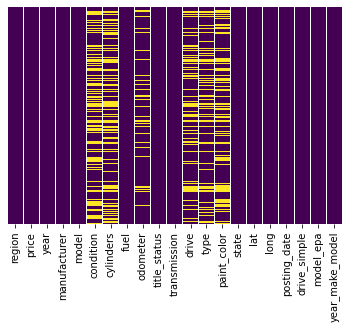

In [17]:
# CHECKING FOR MISSING VALUES AFTER TRIMMING DATA
# SOME COLUMNS ARE KEPT WITH MISSING DATA THAT CAN BE FILLED IN (VIA THE EPA TABLE OR REGRESSION), 
# OR MAY BE USEFUL FOR ANALYZING THE SMALLER SUBSET WHERE IT IS NOT NULL
sns.heatmap(vehicles_trimmed.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [18]:
# DATA FROM https://www.fueleconomy.gov/feg/ws/index.shtml
# THIS DATA WILL BE USED TO FILL IN MISSING CYLINDERS, DRIVE, SIZE, AND TYPE VALUES
epa_vehicles = pd.read_csv('../Raw Data/EPA_Cars_1984-2022.csv')


C:\Users\George\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<AxesSubplot:>

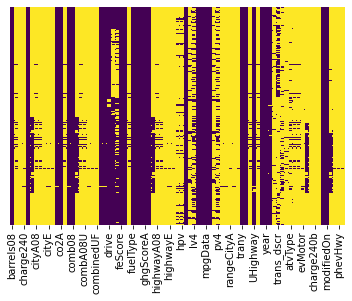

In [19]:
# SET ALL 0 VALUES TO NULL
epa_vehicles = epa_vehicles.replace([float(0), int(0)], np.nan)
# CHECK FOR MISSING DATA:
sns.heatmap(epa_vehicles.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [20]:
# COMPARING vehicles_trimmed FUEL TYPES TO epa_vehicles FUEL TYPES
vehicles_trimmed['fuel'].unique()

<StringArray>
['gas', 'diesel', 'other', 'hybrid', 'electric']
Length: 5, dtype: string

In [21]:
# COMPARING epa_vehicles_trimmed FUEL TYPES TO vehicles_trimmed PRIMARY FUEL TYPES
epa_vehicles['fuelType1'].unique()

array(['Regular Gasoline', 'Premium Gasoline', 'Diesel', 'Natural Gas',
       'Electricity', 'Midgrade Gasoline'], dtype=object)

In [22]:
# COMPARING vehicles_trimmed FUEL TYPES TO epa_vehicles SECONDARY FUEL TYPES
epa_vehicles['fuelType2'].unique()

array([nan, 'Natural Gas', 'E85', 'Propane', 'Electricity'], dtype=object)

In [23]:
# REPLACE FUEL TYPES IN epa_vehicles TO MATCH WHAT IS IN THE vehicles_trimmed DATAFRAME

# REPLACE VARIOUS TYPES OF 'GASSOLINE' WITH 'GAS'
epa_vehicles['fuelType1'] = epa_vehicles['fuelType1'].replace(
    ['Regular Gasoline', 'Premium Gasoline','Midgrade Gasoline'], 'gas')
# REPLACE DIESEL, NATURAL GAS, AND ELECTRICITY WITH THE vehicles_trimmed EQUIVALENT
epa_vehicles['fuelType1'] = epa_vehicles['fuelType1'].replace(
    ['Diesel', 'Natural Gas','Electricity'], 
    ['diesel', 'other', 'electric'])
# IF THE SECONDARY FUEL IS ELECTRICTY, SET FUEL TYPE TO 'hybrid'
epa_vehicles.loc[epa_vehicles['fuelType2'] == 'Electricity', 'fuelType1'] = 'hybrid'
# IF THE SECONDARY FUEL IS NATURAL GAS, SET FUEL TYPE TO 'other'
epa_vehicles.loc[epa_vehicles['fuelType2'] == 'Natural Gas', 'fuelType1'] = 'other'
# IF THE SECONDARY FUEL IS PROPANE, SET FUEL TYPE TO 'other'
epa_vehicles.loc[epa_vehicles['fuelType2'] == 'Propane', 'fuelType1'] = 'other'

# RETURN UNIQUE fuelType1 VALUES FROM THE ipa_vehicles DATAFRAME FRO INSPECTION
epa_vehicles['fuelType1'].unique()

array(['gas', 'diesel', 'other', 'electric', 'hybrid'], dtype=object)

In [24]:
# SPLIT THE "trany" COLUMN AND SELECT THE FIRST ENTRY SO IT MATCHES THE vehicles_trimmed DATA FRAME
epa_vehicles['trany'] = epa_vehicles['trany'].str.split(' ').str[0]
# CHANGE "year" FROM FLOAT TO INT
epa_vehicles['year'] = epa_vehicles['year'].astype(int)
#epa_vehicles.head(5)

In [25]:
# SET "year" TO INT TYPE
epa_vehicles['year'] = epa_vehicles['year'].astype(int)

# CONCATENATE YEAR, MAKE, AND MODEL FOR LOOKUP WITH VEHICLES TABLE
epa_vehicles['year_make_model'] = (epa_vehicles['year'].map(str) +" "+ 
                                   epa_vehicles['make'].map(str) +" "+ 
                                   epa_vehicles['model'].map(str) +" "+ 
                                   epa_vehicles['trany'].map(str) +" "+ 
                                   epa_vehicles['fuelType1'].map(str))
# CHANGE THE year_make_model COLUMN FROM OBJECT TYPE TO A STRING TYPE
epa_vehicles['year_make_model'] = epa_vehicles['year_make_model'].astype('string')
# CHANGE TO LOWER CASE TO MATCH THE vehicles DF
epa_vehicles['year_make_model'] = epa_vehicles['year_make_model'].str.lower()

In [26]:
# CREATE A SET OF THE ORIGINAL COLUMN NAMES TO SEE WHICH COLUMNS WERE REMOVED
epa_vehicles_org_cols = set(epa_vehicles.columns)
# DROP COLUMNS WITH MOSTLY MISSING DATA
epa_vehicles_trimmed = epa_vehicles.dropna(axis = 1, thresh = 40000)
# DROP CREATED ON AND MODIFIED ON COLUMNS
epa_vehicles_trimmed = epa_vehicles_trimmed.drop(['createdOn','modifiedOn'], axis = 1)
# CREATE A SET OF THE CURRENT COLUMN NAMES TO SEE WHICH COLUMNS WERE REMOVED
epa_vehicles_trimmed_cols = set(epa_vehicles_trimmed.columns)
# COLUMNS REMOVED:
#epa_vehicles_org_cols - epa_vehicles_trimmed_cols
epa_vehicles_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43359 entries, 0 to 43358
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   barrels08        43359 non-null  float64
 1   city08           43359 non-null  float64
 2   co2              43088 non-null  float64
 3   co2A             43359 non-null  float64
 4   co2TailpipeGpm   43088 non-null  float64
 5   comb08           43359 non-null  float64
 6   cylinders        43085 non-null  float64
 7   displ            43086 non-null  float64
 8   drive            42173 non-null  object 
 9   feScore          43359 non-null  float64
 10  fuelCost08       43359 non-null  float64
 11  fuelType         43359 non-null  object 
 12  fuelType1        43359 non-null  object 
 13  ghgScore         43359 non-null  float64
 14  ghgScoreA        43347 non-null  float64
 15  highway08        43359 non-null  float64
 16  id               43359 non-null  float64
 17  make        

<AxesSubplot:>

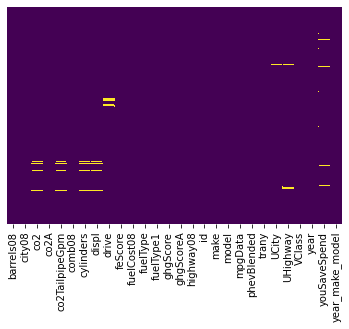

In [27]:
# CHECK FOR MISSING DATA:
sns.heatmap(epa_vehicles_trimmed.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [28]:
for col in epa_vehicles_trimmed.columns:
    if epa_vehicles_trimmed[col].dtype == 'object':
        epa_vehicles_trimmed[col] = epa_vehicles_trimmed[col].astype('string').str.lower()
        

epa_vehicles_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43359 entries, 0 to 43358
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   barrels08        43359 non-null  float64
 1   city08           43359 non-null  float64
 2   co2              43088 non-null  float64
 3   co2A             43359 non-null  float64
 4   co2TailpipeGpm   43088 non-null  float64
 5   comb08           43359 non-null  float64
 6   cylinders        43085 non-null  float64
 7   displ            43086 non-null  float64
 8   drive            42173 non-null  string 
 9   feScore          43359 non-null  float64
 10  fuelCost08       43359 non-null  float64
 11  fuelType         43359 non-null  string 
 12  fuelType1        43359 non-null  string 
 13  ghgScore         43359 non-null  float64
 14  ghgScoreA        43347 non-null  float64
 15  highway08        43359 non-null  float64
 16  id               43359 non-null  float64
 17  make        

In [29]:
epa_vehicles_trimmed.head()

,barrels08,city08,co2,co2A,co2TailpipeGpm,comb08,cylinders,displ,drive,feScore,fuelCost08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,id,make,model,mpgData,phevBlended,trany,UCity,UHighway,VClass,year,youSaveSpend,year_make_model
0,15.695714,19.0,-1.0,-1.0,423.190476,21.0,4.0,2.0,rear-wheel drive,-1.0,1950.0,regular,gas,-1.0,-1.0,25.0,1.0,alfa romeo,spider veloce 2000,y,False,manual,23.3333,35.0000,two seaters,1985,-2250.0,1985 alfa romeo spider veloce 2000 manual gas
1,29.964545,9.0,-1.0,-1.0,807.909091,11.0,12.0,4.9,rear-wheel drive,-1.0,3700.0,regular,gas,-1.0,-1.0,14.0,10.0,ferrari,testarossa,n,False,manual,11.0000,19.0000,two seaters,1985,-11000.0,1985 ferrari testarossa manual gas
2,12.207778,23.0,-1.0,-1.0,329.148148,27.0,4.0,2.2,front-wheel drive,-1.0,1500.0,regular,gas,-1.0,-1.0,33.0,100.0,dodge,charger,y,False,manual,29.0000,47.0000,subcompact cars,1985,NaN,1985 dodge charger manual gas
3,29.964545,10.0,-1.0,-1.0,807.909091,11.0,8.0,5.2,rear-wheel drive,-1.0,3700.0,regular,gas,-1.0,-1.0,12.0,1000.0,dodge,b150/b250 wagon 2wd,n,False,automatic,12.2222,16.6667,vans,1985,-11000.0,1985 dodge b150/b250 wagon 2wd automatic gas
4,17.347895,17.0,-1.0,-1.0,467.736842,19.0,4.0,2.2,4-wheel or all-wheel drive,-1.0,2650.0,premium,gas,-1.0,-1.0,23.0,10000.0,subaru,legacy awd turbo,n,False,manual,21.0000,32.0000,compact cars,1993,-5750.0,1993 subaru legacy awd turbo manual gas


In [30]:
# REMAINING ROWS
epa_vehicles_trimmed['year_make_model'].count()

43359

In [31]:
# CHECK FOR duplicate DATA in year_make_model:
#sns.heatmap(epa_vehicles_trimmed.isnull(),yticklabels=False,cbar=False,cmap='viridis')
epa_vehicles['year_make_model'].nunique()

28911

In [32]:
epa_vehicles_trimmed.head()

,barrels08,city08,co2,co2A,co2TailpipeGpm,comb08,cylinders,displ,drive,feScore,fuelCost08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,id,make,model,mpgData,phevBlended,trany,UCity,UHighway,VClass,year,youSaveSpend,year_make_model
0,15.695714,19.0,-1.0,-1.0,423.190476,21.0,4.0,2.0,rear-wheel drive,-1.0,1950.0,regular,gas,-1.0,-1.0,25.0,1.0,alfa romeo,spider veloce 2000,y,False,manual,23.3333,35.0000,two seaters,1985,-2250.0,1985 alfa romeo spider veloce 2000 manual gas
1,29.964545,9.0,-1.0,-1.0,807.909091,11.0,12.0,4.9,rear-wheel drive,-1.0,3700.0,regular,gas,-1.0,-1.0,14.0,10.0,ferrari,testarossa,n,False,manual,11.0000,19.0000,two seaters,1985,-11000.0,1985 ferrari testarossa manual gas
2,12.207778,23.0,-1.0,-1.0,329.148148,27.0,4.0,2.2,front-wheel drive,-1.0,1500.0,regular,gas,-1.0,-1.0,33.0,100.0,dodge,charger,y,False,manual,29.0000,47.0000,subcompact cars,1985,NaN,1985 dodge charger manual gas
3,29.964545,10.0,-1.0,-1.0,807.909091,11.0,8.0,5.2,rear-wheel drive,-1.0,3700.0,regular,gas,-1.0,-1.0,12.0,1000.0,dodge,b150/b250 wagon 2wd,n,False,automatic,12.2222,16.6667,vans,1985,-11000.0,1985 dodge b150/b250 wagon 2wd automatic gas
4,17.347895,17.0,-1.0,-1.0,467.736842,19.0,4.0,2.2,4-wheel or all-wheel drive,-1.0,2650.0,premium,gas,-1.0,-1.0,23.0,10000.0,subaru,legacy awd turbo,n,False,manual,21.0000,32.0000,compact cars,1993,-5750.0,1993 subaru legacy awd turbo manual gas


In [33]:
# CREATE A DATAFRAME WITH ONLY UNIQUE ELEMENTS OF THE year_make_model COLUMN
epa_vehicles_trimmed_unique = epa_vehicles_trimmed.drop_duplicates(subset = ['year_make_model'])
# CHECK TO MAKE SURE THE COUNT OF THIS COLUMN IS AS EXPECTED
epa_vehicles_trimmed_unique['year_make_model'].count()

28911

In [34]:
# ALL MAKERS FROM CRAIGSLIST
craigslist_make = vehicles_trimmed['manufacturer'].unique()
# ALL MAKERS FROM EPA
epa_make = epa_vehicles_trimmed_unique['make'].str.lower().unique()

# ITTERATE THROUGH MAKERS IN BOTH LISTS AND SHOW MISS-MATCHES ALONG WITH THEIR MOST LIKELY MATCH
for manuf in craigslist_make:
    match = False
    for make in epa_make:
        if manuf == make:
            match = True
            break
    if match == False:
        possible_matches = process.extract(manuf, epa_make, limit=2)
        print(f"craigslist {manuf}:".ljust(30)  + 
              f"{possible_matches}".ljust(50) + 
              f"n={vehicles_trimmed['manufacturer'].loc[vehicles_trimmed['manufacturer'] == manuf].count()}")
        #print(f"No Match! craigslist {manuf} has no epa equivalent")

craigslist rover:             [('land rover', 90), ('vector', 55)]              n=1341
craigslist alfa-romeo:        [('alfa romeo', 100), ('geo', 60)]                n=173
craigslist harley-davidson:   [('byd', 60), ('azure dynamics', 55)]             n=112
craigslist aston-martin:      [('aston martin', 100), ('smart', 72)]            n=34
craigslist datsun:            [('daihatsu', 71), ('saturn', 67)]                n=2


In [35]:
# DROP harley-davidson AND datsun (THERE ARE NOT MANY AND THEY DO NOT CORRELATE WITH MAKERS IN epa_vehicles)
vehicles_trimmed = vehicles_trimmed.loc[
    (vehicles_trimmed['manufacturer'] != 'harley-davidson') & 
    (vehicles_trimmed['manufacturer'] != 'datsun')]

In [36]:
# CONVERT ALL CLOSELY MATCHED vehicles_trimmed['manufacturer'] TO MATCH THE epa_vehicles VALUE

# ALL MAKERS FROM CRAIGSLIST
craigslist_make = vehicles_trimmed['manufacturer'].unique()
# ALL MAKERS FROM EPA
epa_make = epa_vehicles_trimmed_unique['make'].str.lower().unique()

# ITTERATE THROUGH MAKERS IN BOTH LISTS AND SHOW MISS-MATCHES ALONG WITH THEIR MOST LIKELY MATCH
for manuf in craigslist_make:
    match = False
    for make in epa_make:
        if manuf == make:
            match = True
            break
    if match == False:
        possible_matches = process.extract(manuf, epa_make, limit=1)
        for match in possible_matches:
            if match[1] > 85:
                vehicles_trimmed['manufacturer'].loc[vehicles_trimmed['manufacturer'] == manuf] = match[0]

In [37]:
# MATCH THE DATA FRAMES

# AFTER THINKING ABOUT IT AND DOING A BIT OF RESEARCH, RUNNING FUZZYWUZZY TO MATCH OVER 20,000 COLUMNS IS A BIT MUCH.
# A BETTER APPROACH IS TO BREAK THE DATA INTO CHUNKS BASED ON YEAR AND MAKER (SINCE THESE WILL MATCH ACROSS DATA FRAMES)
    # AND THEN MATCH AFTER THAT. 

In [38]:
for i in epa_vehicles_trimmed_unique['model'].loc[epa_vehicles_trimmed_unique['make'] == 'ford'].unique():
    print(i)

taurus
taurus sho
thunderbird
e150 club wagon
ltd crown victoria
escort wagon
taurus wagon
f150 pickup 2wd
f250 pickup 2wd
ranger pickup 2wd
f150 pickup 4wd
ranger pickup 4wd
aerostar van
aerostar van awd
e150 econoline 2wd
e250 econoline 2wd
aerostar wagon
aerostar wagon awd
explorer 2wd
bronco 4wd
explorer 4wd
aspire
mustang
probe
escort
tempo
bronco ii 4wd
crown victoria police
lightning f150 2wd
ranger pickup cab chassis
contour
taurus ffv
exp
crown victoria
laser
windstar fwd van
windstar fwd wagon
crown victoria cng
f250
ltd
f250 pickup 4wd
expedition 2wd
expedition 4wd
escort zx2
f250 pickup 2wd cng
ltd wagon
e250 econoline 2wd cng
ranger 2wd ffv
ranger 4wd ffv
focus
focus station wagon
lightning pickup 2wd
postal vehicle
windstar fwd cargo van
f150 pickup 2wd cng
explorer sport trac 2wd
explorer sport trac 4wd
escape 2wd
explorer sport 2wd
explorer usps 2wd
escape 4wd
explorer sport 4wd
explorer usps 4wd
f150 cng
e250 cng
taurus wagon ffv
explorer usps 4wd ffv
f150 dual-fuel 2w

In [39]:
epa_vehicles_trimmed_unique[
    (epa_vehicles_trimmed_unique['fuelType1'].str.lower() == 'diesel') & 
    (epa_vehicles_trimmed_unique['year'] == 2021)
    ]

,barrels08,city08,co2,co2A,co2TailpipeGpm,comb08,cylinders,displ,drive,feScore,fuelCost08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,id,make,model,mpgData,phevBlended,trany,UCity,UHighway,VClass,year,youSaveSpend,year_make_model
35933,15.924375,22.0,412.0,-1.0,412.0,24.0,6.0,3.0,4-wheel drive,5.0,1900.0,diesel,diesel,4.0,-1.0,28.0,42691.0,land rover,range rover,n,False,automatic,27.9000,NaN,standard sport utility vehicle 4wd,2021,-2000.0,2021 land rover range rover automatic diesel
35934,15.924375,22.0,412.0,-1.0,412.0,24.0,6.0,3.0,4-wheel drive,5.0,1900.0,diesel,diesel,4.0,-1.0,28.0,42692.0,land rover,range rover sport,n,False,automatic,27.9000,NaN,standard sport utility vehicle 4wd,2021,-2000.0,2021 land rover range rover sport automatic di...
35990,17.372045,19.0,455.0,-1.0,455.0,22.0,4.0,2.8,4-wheel drive,4.0,2100.0,diesel,diesel,4.0,-1.0,28.0,42749.0,chevrolet,colorado 4wd,n,False,automatic,24.2000,39.7000,small pickup trucks 4wd,2021,-3000.0,2021 chevrolet colorado 4wd automatic diesel
35992,20.115000,18.0,525.0,-1.0,525.0,19.0,4.0,2.8,4-wheel drive,3.0,2400.0,diesel,diesel,3.0,-1.0,22.0,42750.0,chevrolet,colorado zr2 4wd,n,False,automatic,21.1000,31.2493,small pickup trucks 4wd,2021,-4500.0,2021 chevrolet colorado zr2 4wd automatic diesel
35993,17.372045,19.0,455.0,-1.0,455.0,22.0,4.0,2.8,4-wheel drive,4.0,2100.0,diesel,diesel,4.0,-1.0,28.0,42751.0,gmc,canyon 4wd,n,False,automatic,24.2000,39.7000,small pickup trucks 4wd,2021,-3000.0,2021 gmc canyon 4wd automatic diesel
36058,16.616739,20.0,435.0,-1.0,435.0,23.0,4.0,2.8,rear-wheel drive,5.0,2000.0,diesel,diesel,4.0,-1.0,30.0,42811.0,chevrolet,colorado 2wd,n,False,automatic,25.2000,42.4000,small pickup trucks 2wd,2021,-2500.0,2021 chevrolet colorado 2wd automatic diesel
36059,16.616739,20.0,435.0,-1.0,435.0,23.0,4.0,2.8,rear-wheel drive,5.0,2000.0,diesel,diesel,4.0,-1.0,30.0,42812.0,gmc,canyon 2wd,n,False,automatic,25.2000,42.4000,small pickup trucks 2wd,2021,-2500.0,2021 gmc canyon 2wd automatic diesel
36228,15.287400,22.0,411.0,-1.0,411.0,25.0,6.0,3.0,4-wheel drive,5.0,1850.0,diesel,diesel,4.0,-1.0,29.0,42965.0,jeep,wrangler 4dr ecodiesel 4wd,n,False,automatic,28.1996,41.2000,small sport utility vehicle 4wd,2021,-1750.0,2021 jeep wrangler 4dr ecodiesel 4wd automatic...
36229,16.616739,21.0,442.0,-1.0,442.0,23.0,6.0,3.0,4-wheel drive,5.0,2000.0,diesel,diesel,4.0,-1.0,26.0,42966.0,jeep,wrangler rubic 4dr ecodiesel 4wd,y,False,automatic,28.1996,41.2000,small sport utility vehicle 4wd,2021,-2500.0,2021 jeep wrangler rubic 4dr ecodiesel 4wd aut...
36276,14.699423,22.0,390.0,-1.0,390.0,26.0,6.0,3.0,rear-wheel drive,5.0,1750.0,diesel,diesel,5.0,-1.0,32.0,43007.0,ram,1500 2wd,n,False,automatic,28.7000,NaN,standard pickup trucks 2wd,2021,-1250.0,2021 ram 1500 2wd automatic diesel


In [185]:
years = range(1984,1985)
data_year = []
data_manuf = []
data_fuel = []
data_trany = []
data_model = []
data_match = []

for year in years:
    manufacturers = vehicles_trimmed['manufacturer'].loc[vehicles_trimmed['year'] == year].unique()
    epa_manufacturers = epa_vehicles_trimmed_unique['make'].loc[epa_vehicles_trimmed_unique['year'] == year].unique()
    for manuf in manufacturers:
        fuels = vehicles_trimmed['fuel'].loc[
            (vehicles_trimmed['year'] == year) & 
            (vehicles_trimmed['manufacturer'] == manuf)].unique()
        epa_fuels = epa_vehicles_trimmed_unique['fuelType1'].loc[
            (epa_vehicles_trimmed_unique['year'] == year) & 
            (epa_vehicles_trimmed_unique['make'] == manuf)].unique()
        for fuel in fuels:
            transmissions = vehicles_trimmed['transmission'].loc[
                (vehicles_trimmed['year'] == year) & 
                (vehicles_trimmed['manufacturer'] == manuf) & 
                (vehicles_trimmed['fuel'] == fuel)].unique()
            epa_transmissions = epa_vehicles_trimmed_unique['trany'].loc[
                (epa_vehicles_trimmed_unique['year'] == year) & 
                (epa_vehicles_trimmed_unique['make'] == manuf) & 
                (epa_vehicles_trimmed_unique['fuelType1'] == fuel)].unique()
            for trany in transmissions:
                models = vehicles_trimmed['model_epa'].loc[
                    (vehicles_trimmed['year'] == year) & 
                    (vehicles_trimmed['manufacturer'] == manuf) & 
                    (vehicles_trimmed['fuel'] == fuel) &
                    (vehicles_trimmed['transmission'] == trany)].unique()
                    
                epa_models = epa_vehicles_trimmed_unique['model'].loc[
                    (epa_vehicles_trimmed_unique['year'] == year) & 
                    (epa_vehicles_trimmed_unique['make'] == manuf) & 
                    (epa_vehicles_trimmed_unique['fuelType1'] == fuel) &
                    (epa_vehicles_trimmed_unique['trany'] == trany)].unique()
                    
                for model in models:
                    matches = process.extract(model, epa_models,scorer=fuzz.token_set_ratio,limit = 1)
                    print(f"{model}: {matches}")
                    data_year.append(year)
                    data_manuf.append(manuf)
                    data_fuel.append(fuel)
                    data_trany.append(trany)
                    data_model.append(model)


data = {'year': data_year, 'manuf':data_manuf,'fuel':data_fuel,'trany':data_trany,'model':data_model}

caprice : [('impala/caprice', 100)]
c10 : [('c10 pickup 2wd', 100)]
s10 : [('s10 pickup 2wd', 100)]
p30 step van 2wd: [('g30 sport van 2wd', 79)]
silverado c30 2wd: [('g30 van 2wd', 64)]
corvette c5 2wd: [('corvette', 100)]
custom deluxe 2wd: [('el camino pickup 2wd', 54)]
g20 2wd: [('g30 van 2wd', 67)]
corvette convertible 2wd: [('corvette', 100)]
suburban 2wd: [('suburban c10 2wd', 100)]
camaro z28 : [('camaro', 100)]
corvette coupe 2wd: [('corvette', 100)]
corvette : [('corvette', 100)]
1984 2wd: [('s10 pickup 2wd', 55)]
20 van 2wd: [('g10/20 van 2wd', 100)]
coupe : [('corvette', 46)]
c10 pickup 2wd: [('c10 pickup 2wd', 100)]
blazer : [('s10 blazer 2wd', 100)]
monte carlo 2wd: [('monte carlo', 100)]
corvette 2wd: [('corvette', 100)]
camero : [('camaro', 83)]
s10 tahoe : [('s10 blazer 2wd', 52)]
blazer 4wd: [('k5/k10 blazer 4wd', 100)]
monte carlo : [('monte carlo', 100)]
c10 silverado 4wd: [('suburban c10 2wd', 61)]
camaro : [('camaro', 100)]
silverado 2wd: [('s10 blazer 2wd', 52)]


In [187]:
df = pd.DataFrame(data)
df

,year,manuf,fuel,trany,model
0,1984,chevrolet,gas,automatic,caprice
1,1984,chevrolet,gas,automatic,c10
2,1984,chevrolet,gas,automatic,s10
3,1984,chevrolet,gas,automatic,p30 step van 2wd
4,1984,chevrolet,gas,automatic,silverado c30 2wd
...,...,...,...,...,...
212,1984,ram,gas,automatic,350 custom 2wd
213,1984,chrysler,gas,automatic,lebaron
214,1984,chrysler,gas,automatic,lebron convertible 2wd
215,1984,honda,gas,automatic,accord lx 2wd


In [174]:
year = 2021
fuel = 'gas'
maker = 'ford'
drive = 'automatic'

test_possible_epa_vehicles2 = (
    epa_vehicles_trimmed_unique['model'].loc[(epa_vehicles_trimmed_unique['year'] == year) & 
    (epa_vehicles_trimmed_unique['make'].str.lower() == maker) & 
    (epa_vehicles_trimmed_unique['trany'].str.lower() == drive) &
    (epa_vehicles_trimmed_unique['fuelType1'].str.lower() == fuel)]
    )
test_possible_epa_vehicles2

36442                     ecosport fwd
36446                     ecosport awd
36560          transit connect van fwd
36561    transit connect wagon lwb fwd
36562             transit connect usps
36564          transit connect van ffv
36567    transit connect wagon lwb ffv
36581                     explorer rwd
36586                     explorer awd
36589                 explorer ffv awd
36590                 explorer hev awd
36774                  f150 pickup 2wd
36776              f150 pickup 2wd ffv
36781                  f150 pickup 4wd
36783              f150 pickup 4wd hev
36784              f150 pickup 4wd ffv
36800                 explorer hev rwd
36869                       ranger 4wd
36870                 bronco sport 4wd
36920                   expedition 2wd
36922               expedition max 2wd
36929                   expedition 4wd
36930               expedition max 4wd
36942                               gt
36945                   mustang mach 1
36949              f150 p

In [103]:
test_actual_vehicles2 = (
    vehicles_trimmed['model_epa'].loc[(vehicles_trimmed['year'] == year) & 
    (vehicles_trimmed['manufacturer'] == maker) & 
    (vehicles_trimmed['transmission'].str.lower() == drive) &
    (vehicles_trimmed['fuel'] == fuel)]
    )
test_actual_vehicles2

110582           explorer limited 
112933       f150 xlt f-150 truck 
116082         f350 super duty 4wd
119103         f250 super duty 4wd
119268         f350 super duty 4wd
119269         f350 super duty 4wd
212886                explorer 4wd
233580         f250 super duty 4wd
234055         f350 super duty 4wd
234058         f350 super duty 4wd
239982                   explorer 
250826    explorer limited 4x4 4wd
268411                     fusion 
268426        e-series cutaway 2wd
271514        e-series cutaway 2wd
273794        e-series cutaway 2wd
274098        e-series cutaway 2wd
275285         e350 super duty 2wd
276405         e350 super duty 2wd
276418        e-series cutaway 2wd
282990        e-series cutaway 2wd
285398        e-series cutaway 2wd
287556        e-series cutaway 2wd
353551         f250 super duty 4wd
354362         f350 super duty 4wd
354366         f350 super duty 4wd
358924         f250 super duty 4wd
359289         f350 super duty 4wd
359290         f350 

In [104]:
for model in test_actual_vehicles2:
    matches = process.extract(model, test_possible_epa_vehicles2,scorer=fuzz.token_set_ratio,limit = 1)
    print(f"{model}: {matches}")

explorer limited : [('explorer rwd', 80, 36581)]
f150 xlt f-150 truck : [('f150 pickup 2wd ffv', 51, 36776)]
f350 super duty 4wd: [('f150 pickup 4wd', 59, 36781)]
f250 super duty 4wd: [('f150 pickup 4wd', 59, 36781)]
f350 super duty 4wd: [('f150 pickup 4wd', 59, 36781)]
f350 super duty 4wd: [('f150 pickup 4wd', 59, 36781)]
explorer 4wd: [('explorer rwd', 92, 36581)]
f250 super duty 4wd: [('f150 pickup 4wd', 59, 36781)]
f350 super duty 4wd: [('f150 pickup 4wd', 59, 36781)]
f350 super duty 4wd: [('f150 pickup 4wd', 59, 36781)]
explorer : [('explorer rwd', 100, 36581)]
explorer limited 4x4 4wd: [('explorer rwd', 80, 36581)]
fusion : [('mustang', 46, 37009)]
e-series cutaway 2wd: [('ranger 2wd incomplete', 49, 36953)]
e-series cutaway 2wd: [('ranger 2wd incomplete', 49, 36953)]
e-series cutaway 2wd: [('ranger 2wd incomplete', 49, 36953)]
e-series cutaway 2wd: [('ranger 2wd incomplete', 49, 36953)]
e350 super duty 2wd: [('f150 pickup 2wd', 53, 36774)]
e350 super duty 2wd: [('f150 pickup 2wd